<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/Lab_3_motody_regularyzacji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metody regularyzacji w treningu sieci neuronowych

## Zad. 1a. Zjawisko niedopasowania oraz przeuczenia na przykładzie regresji 1D

W tym zadaniu poznasz koncepcje *underfittingu* (niedopasowania modelu) i *overfittingu* (nadmiernego dopasowania modelu) na prostym przykładzie regresji jednowymiarowej. Użyjemy małej sieci neuronowej MLP (Multi-Layer Perceptron) do aproksymacji funkcji z dodanym szumem.

Dostarczony kod demonstruje dopasowanie różnych konfiguracji sieci neuronowej do danych treningowych pochodzących z funkcji:  
Celem jest trening modelu dobrze odwzorowującego funkcję (trend), z której pochodzą dane:

$$ y = \sin(2\pi x) + 0.5 \sin(4\pi x) + 0.3 \cos(6\pi x) + \epsilon $$

gdzie $ x \in [0, 1] $, a $ \epsilon $ to szum gaussowski o odchyleniu standardowym 0.2.
Dane treningowe składają się z 25 punktów, a testowe z 200 punktów (bez szumu).

### Sprawdź następujące konfiguracje:
* 1 warstwa ukryta z 2 neuronami
* 2 warstwy ukryte po 10 neuronów
* 3 warstwy ukryte po 50 neuronów

**Dla każdej konfiguracji określ czy mamy do czynienia z przeuczeniem lub niedopasowaniem.**


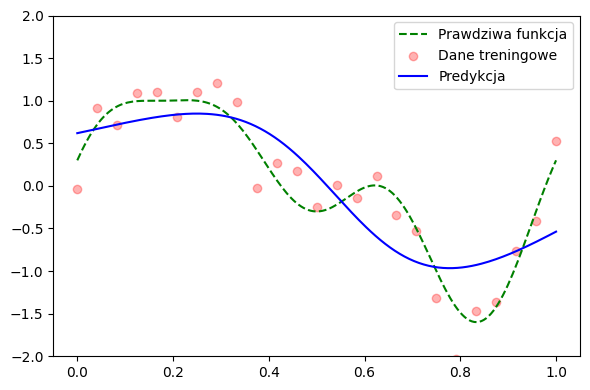

In [ ]:
# @title ## Kod do zadania

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ustalamy ziarno generatora dla powtarzalności wyników:
torch.manual_seed(283)
np.random.seed(283)

def fn(x):
    " Funkcja, którą chcemy nauczyć się odwzorowywać "
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x) + 0.3 * np.cos(6 * np.pi * x)

def make_data(n=50):
    x = np.linspace(0, 1, n)
    y_true = fn(x)
    noise = np.random.randn(n) * 0.2
    # Zazwyczaj dane treningowe obarczone są pewnym szumem, tu również go dodajemy:
    y = y_true + noise
    return x.reshape(-1, 1).astype(np.float32), y.reshape(-1, 1).astype(np.float32), y_true.reshape(-1, 1).astype(np.float32)

x_train, y_train, y_true = make_data(25)
x_test = np.linspace(0, 1, 200).reshape(-1, 1).astype(np.float32)
y_test_true = fn(x_test)


class MLP(nn.Module):
    def __init__(self, hidden_layers=[10]):
        " Elementy hidden_layers określają liczbę neuronów w warstwach ukrytych "
        super().__init__()
        layers = []
        in_dim = 1  # Na wej. mamy dane jednowymiarowe
        for h in hidden_layers:
            layers += [nn.Linear(in_dim, h), nn.Tanh()]
            in_dim = h  # Kolejne wej. są wyjściami z poprzedniej warstwy
        layers += [nn.Linear(in_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def train_model(hidden_layers, weight_decay=0.0, epochs=1000):
    model = MLP(hidden_layers)
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    x_t = torch.tensor(x_train)
    y_t = torch.tensor(y_train)
    losses = []
    for _ in range(epochs):
        opt.zero_grad()
        y_pred = model(x_t)
        loss = loss_fn(y_pred, y_t)
        losses.append(loss.item())
        loss.backward()
        opt.step()
    return model, losses


def solve(hidden_layers=[2], weight_decay=0.0):
    model, _ = train_model(hidden_layers, weight_decay)

    plt.figure(figsize=(6, 4))
    with torch.no_grad():
        y_pred = model(torch.tensor(x_test)).numpy()

    plt.plot(x_test, y_test_true, 'g--', label='Prawdziwa funkcja')
    plt.scatter(x_train, y_train, color='red', label='Dane treningowe', alpha=0.3)
    plt.plot(x_test, y_pred, 'b', label='Predykcja')
    plt.ylim(-2, 2)
    plt.legend()
    plt.tight_layout()
    plt.show()

solve(hidden_layers=[2], weight_decay=0)

## Zad. 1b. Wpływ regularyzacji L2

Sprawdź jak regularyzacja L2 (`weight_decay`) wpływa na efekty treningu.

Jaka wartość współczynnika `weight_decay` jest odpowiednia, rozważ: `1e-2`, `1e-3`, `1e-4`?

**Czy regularyzacja L2 pomaga w uogólnianiu?**

In [ ]:
# Rozwiązanie

## Zad. 1c. Liczność zbioru danych

Sprawdź jak zmieni się sytuacja, gdy zbiór treningowy będzie liczył 250 punktów zamiast 25.
Rozważ przypadki **z oraz bez regularyzacji L2**.